In [6]:
import torch
import torchvision
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F

torch.set_printoptions(precision=2)     # 计算结果保留两位小数，四舍五入

def bbox_corner_to_center(boxes):
    """
    :param boxes: size(n, 4) 可以是批量，也可以是单个bbox 但要符合批量维度的形式
    :return: size(n, 4)
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    w, h = x2 - x1, y2 - y1
    return torch.stack(tensors=(cx, cy, w, h), dim=-1)      # Concatenates a sequence of tensors along a new dimension.


def bbox_center_to_corner(boxes):
    """
    :param boxes:size(n, 4)  可以是批量，也可以是单个bbox 但要符合批量维度的形式
    :return: size(n, 4)
    """
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1, x2 = cx - w / 2, cx + w / 2
    y1, y2 = cy - h / 2, cy + h / 2
    return torch.stack(tensors=(x1, y1, x2, y2), dim=-1)    # 返回的变量顺序要格外注意，耗时！


def bbox_to_rect(bboxCorner, color):
    """
    :param bboxCorner: 左上右下坐标，但plt.Rectangle要左上、宽、高
    :param color:
    :return:
    """
    return plt.Rectangle(xy=(bboxCorner[0], bboxCorner[1]), width=bboxCorner[2] - bboxCorner[0],
                         height=bboxCorner[3] - bboxCorner[1], fill=False, edgecolor=color, linewidth=2)


def multibox_prior(data, sizes, ratios):
    """
    为输入图像data生成各种大小比例的anchors并返回。
    :param data: 输入图像[b, c, h, w]，只用到了h w属性，没有对图像作操作
    :param sizes:
    :param ratios:
    :return:
    """
    in_hight, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = num_sizes + num_ratios - 1
    sizes_tensor = torch.tensor(sizes, device=device)
    ratios_tensor = torch.tensor(ratios, device=device)

    offset_h, offset_w = .5, .5
    step_h, step_w = 1 / in_hight, 1 / in_width

    center_h = (torch.arange(in_hight, device=device) + offset_h) * step_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * step_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')    # https://blog.csdn.net/weixin_39504171/article/details/106356977
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # h w for anchors, it's not identified with book here
    h = torch.cat((sizes_tensor / torch.sqrt(ratios_tensor[0]), sizes_tensor[0] / torch.sqrt(ratios_tensor[1:])))
    w = torch.cat((sizes_tensor * torch.sqrt(ratios_tensor[0]), sizes_tensor[0] * torch.sqrt(ratios_tensor[1:]))) * in_hight / in_width

    # w h的长度都是boxes_per_pixel，即每个像素都应该有boxes_per_pixel个(w, h, -w, -h)以生成boxes_per_pixel个不同的anchors
    anchors_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_hight * in_width, 1) / 2

    out_grid = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchors_manipulations
    return output.unsqueeze(0)


def show_boxes(axes, bboxes, labels=None, colors=None):     # bboxes 6 cpu tensor
    def _make_list(obj, default_value=None):
        if obj is None:
            obj = default_value
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, list('bgrmc'))
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        print(f'************* {rect}')
        print(f'{type(rect)}')
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))


def bbox_iou(boxes1, boxes2):
    """
    :param boxes1:[boxes数量, 4]
    :param boxes2:[boxes数量, 4]
    :return:[boxes1数量，boxes2数量]
    """
    boxes_area = lambda boxes: (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    areas1 = boxes_area(boxes1)
    areas2 = boxes_area(boxes2)
    inter_uplefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inter = torch.clamp(inter_lowrights - inter_uplefts, min=0)
    inter_areas = inter[:, :, 0] * inter[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas


def assign_anchors_to_bbox(gts, anchors, device, iou_threshold=.5):
    """
    将最接近的gts分配给anchors\n
    :param gts: [boxes数量, 4]
    :param anchors: [boxes数量, 4]
    :param device:
    :param iou_threshold:
    :return:[anchors数量,]
    """
    num_anchors, num_gts = anchors.shape[0], gts.shape[0]
    ious = bbox_iou(anchors, gts)
    anchors_bbox_map = torch.full(size=(num_anchors, ), fill_value=-1, dtype=torch.long, device=device)

    max_ious, inds = torch.max(ious, dim=1)     # dim=1 the dimension to reduce. 这里dim=1指行
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)    # 得到了分配到bbox的anchors索引
    bbox_j = inds[max_ious >= iou_threshold]    # 得到了分配出去的bbox索引
    anchors_bbox_map[anc_i] = bbox_j

    col_discard = torch.full(size=(num_anchors, ), fill_value=-1)
    row_discard = torch.full(size=(num_gts, ), fill_value=-1)
    for _ in range(num_gts):
        max_idx = ious.argmax()
        box_idx = (max_idx % num_gts).long()
        anc_idx = (max_idx / num_gts).long()
        ious[:, box_idx] = col_discard
        ious[anc_idx, :] = row_discard
        anchors_bbox_map[anc_idx] =box_idx
    return anchors_bbox_map


def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """
    对锚框偏移量的转换
    :param anchors:
    :param assigned_bb: 分配给anchor的gt
    :param eps:
    :return:
    """
    c_anc = bbox_corner_to_center(anchors)
    c_assigned_bb = bbox_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset


def multibox_target(anchors, labels):
    """
    使用gt标记anchors，类别、偏移量
    :param anchors: [batch, anchors数量, 4]
    :param labels: [batch, anchors数量, 5]
    :return:
    """
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)   # https://pytorch.org/docs/stable/generated/torch.squeeze.html
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):     # 示例中，batch大小仅为1，因此下面是所有的labels和所有的anchors运算
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchors_to_bbox(label[:, 1:], anchors, device)    # 某个样本的gts分配给所有的anchors？？？——可能此处每个样本的anchors是相同的
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)

        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return bbox_offset, bbox_mask, class_labels


#@save
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = bbox_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = bbox_center_to_corner(pred_bbox)
    return predicted_bbox


def nms(boxes, scores, iou_threshold):
    """ 返回保留的预测框索引 """
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []
    while B.numel():
        i = B[0]
        keep.append(i)
        if B.numel() == 1:
            break
        ious = bbox_iou(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(ious <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)


def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=.5, pos_threshold=.0099999):
    """
    使用nms预测边界框
    :param cls_probs: [batch, num_classes, num_anchors]
    :param offset_preds:[batch, num_anchors, 4]
    :param anchors: [batch, ]
    :param num_threshold:
    :param pos_threshold:
    :return:
    """
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)    # [num_classes, num_anchors] [num_anchors, 4]
        conf, class_id = torch.max(cls_prob[1:], dim=0)     # dim (int) – the dimension to reduce.
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)


def display_anchors(fmap_w, fmap_h, s):
    """
    fmap上生成锚框，映射到原图
    :param fmap_w:
    :param fmap_h:
    :param s:
    :return:
    """
    fmap = torch.zeros(size=(1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, .5])
    bbox_scale = torch.tensor(data=(w, h, w, h))
    show_boxes(fig.axes, anchors[0] * bbox_scale)


def read_data_banans(is_train=True):
    """ 读取图像和标签，并返回2个list """
    data_dir = r'../data/banana-detection'
    csv_name = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_name)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        img = cv2.imread(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(torch.from_numpy(img).permute(2, 0, 1))       # cv2读取的是H W C
        targets.append(list(target))
    return images, torch.tensor(data=targets).unsqueeze(1) / 256


class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_banans(is_train)
        print(f'read {len(self.features)} {"training" if is_train else "validation"} examples.')

    def __getitem__(self, item):
        return self.features[item].float(), self.labels[item]

    def __len__(self):
        return len(self.features)


def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False), batch_size, shuffle=False)
    return train_iter, val_iter


def cls_predictor(num_inputs, num_anchors, num_classes):
    """
    用conv实现分类层
    :param num_inputs: 输入通道数
    :param num_anchors: 每个像素生成的anchors数量
    :param num_classes: 预测类别数
    :return:
    """
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)


def bbox_predictor(num_inputs, num_anchors):
    """
    用conv实现边界框预测层
    :param num_inputs: 输入通道数
    :param num_anchors: 每个像素生成的anchors数量
    :return:
    """
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)


def forward(x, block):
    return block(x)


def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)


def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)


def down_sample_blk(in_channels, out_channels):
    """ 输入通道数in_channels, 输出通道数out_channels, 高、宽减半 """
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)


def base_net():
    """ 基础网络，由3个down_sample_blk堆叠而成 """
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)


def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i in [2, 3]:
        blk = down_sample_blk(128, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d(output_size=(1, 1))
    return blk


def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    """ 每个块的forward，都会输出(特征图、anchors、类别预测、偏移量预测)"""
    Y = blk(X)
    anchors = multibox_prior(Y, size, ratio)
    cls_pred = cls_predictor(Y)
    bbox_pred = bbox_predictor(Y)
    return Y, anchors, cls_pred, bbox_pred


class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                                                                     getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds




In [2]:
# # fig = plt.figure()    # plt.imshow()也可以返回fig，这句可以不写
# img = plt.imread(fname=r'images/catdog.jpg')    # h w c
# fig = plt.imshow(img)
# # plt.show()
#
# dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
# # boxes = torch.tensor(data=(dog_bbox, cat_bbox))
# # print(f'{boxes.shape}\n{bbox_center_to_corner(bbox_corner_to_center(boxes)) == boxes}')
#
# # fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
# # fig.axes.add_patch(bbox_to_rect(cat_bbox, 'r'))
# # plt.show()
#
# img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
# print(f'img, numpy->tensor img.shape {img.shape}')
# Y = multibox_prior(img, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
# print(Y.shape)
# h, w = img.shape[-2:]    # h w
# boxes = Y.reshape(h, w, 5, 4)
# print(boxes[250, 250, 0, :])
#
# bbox_scale = torch.tensor((w, h, w, h))
# # show_boxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
# #            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])
# # plt.show()
#
# # ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
# #                              [1, 0.55, 0.2, 0.9, 0.88]])
# # anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
# #                         [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
# #                         [0.57, 0.3, 0.92, 0.9]])
# # show_boxes(fig.axes, ground_truth[:, 1:] * bbox_scale, labels=['dog', 'cat'], colors='k')
# # show_boxes(fig.axes, anchors * bbox_scale, list('01234'))
# # plt.show()
# #
# # labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))
# # print(labels[2])
# # print(labels[1])
# # print(labels[0])
#
# anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
#                         [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
# offset_preds = torch.tensor([0] * anchors.numel())
# cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
#                           [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
#                           [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率
# # show_boxes(fig.axes, anchors * bbox_scale, ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])
# # plt.show()
#
# # output = multibox_detection(cls_probs.unsqueeze(0), offset_preds.unsqueeze(0), anchors.unsqueeze(0))
# # print(output)
#
# # for i in output[0].detach().numpy():
# #     if i[0] == -1:
# #         continue
# #     label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
# #     show_boxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)
# # plt.show()
#
# # display_anchors(fmap_w=1, fmap_h=1, s=[.5])
# # plt.show()
#
# batch_size, edge_size = 32, 256
# train_iter, _ = load_data_bananas(batch_size)
# batch = next(iter(train_iter))
# print(batch[0].shape, batch[1].shape)
#
# # imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255    # B C H W --> B H W C, 显示的时候还是要转成cv2维度
# # fig, axes = plt.subplots(nrows=2, ncols=5)
# # for img, ax, label in zip(imgs, axes.flatten(), batch[1][:10]):
# #     ax.imshow(img)
# #     show_boxes(ax, [label[0][1:5] * edge_size], colors=['w'])
# # plt.show()

Y1 = forward(torch.zeros(size=(2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros(size=(2, 16, 10, 10)), cls_predictor(16, 3, 10))
print(Y1.shape, Y2.shape)

Y = concat_preds([Y1, Y2])
print(Y.shape)

Y = forward(torch.zeros((2, 3, 256, 256)), base_net())
print(Y.shape)

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
            [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

net = TinySSD(num_classes=1)
X = torch.zeros(size=(32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
print(f'output anchors {anchors.shape}\n'
        f'output cls_preds {cls_preds.shape}\n'
        f'output bbox_preds {bbox_preds.shape}')

batch_size = 16
train_iter, _ = load_data_bananas(batch_size)

device, net = torch.device(f'cuda:0') if torch.cuda.device_count() else torch.device('cpu'), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=.1, weight_decay=5e-4)

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    box = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    return cls + box

def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum()) / cls_labels.numel()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum()) / bbox_labels.numel()





torch.Size([2, 55, 20, 20]) torch.Size([2, 33, 10, 10])
torch.Size([2, 25300])
torch.Size([2, 64, 32, 32])
output anchors torch.Size([1, 5444, 4])
output cls_preds torch.Size([32, 5444, 2])
output bbox_preds torch.Size([32, 21776])
read 1000 training examples.
read 100 validation examples.


In [3]:

num_epochs = 5
net = net.to(device)

for epoch in range(num_epochs):
    net.train()
    for i, (features, labels) in enumerate(train_iter):
        trainer.zero_grad()
        X, Y = features.to(device), labels.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()

        print(f'epoch {epoch + 1}/{num_epochs} iter {i + 1}/{len(train_iter)} cls_eval:{cls_eval(cls_preds, cls_labels)}  bbox_eval:{bbox_eval(bbox_preds, bbox_labels, bbox_masks)}  loss:{l.sum()}')
    print(f'***********************************')

epoch 1/10 iter 1/63 cls_eval:0.5913850110213079  bbox_eval:0.005575347875164853  loss:10.876523971557617
epoch 1/10 iter 2/63 cls_eval:0.982985855988244  bbox_eval:0.0049469556815478835  loss:1.6462266445159912
epoch 1/10 iter 3/63 cls_eval:0.9893001469507715  bbox_eval:0.005965877507733213  loss:1.5366911888122559
epoch 1/10 iter 4/63 cls_eval:0.9915273695811903  bbox_eval:0.005398319014549956  loss:1.2446916103363037
epoch 1/10 iter 5/63 cls_eval:0.9910911094783248  bbox_eval:0.006452525389010551  loss:1.1310173273086548
epoch 1/10 iter 6/63 cls_eval:0.9918373438648053  bbox_eval:0.006349044368163703  loss:1.059949278831482
epoch 1/10 iter 7/63 cls_eval:0.9929165135929464  bbox_eval:0.005571122908749885  loss:1.022662878036499
epoch 1/10 iter 8/63 cls_eval:0.9926983835415136  bbox_eval:0.006452348107892218  loss:0.9452739953994751
epoch 1/10 iter 9/63 cls_eval:0.9938579169728141  bbox_eval:0.005488878133803234  loss:0.9084591269493103
epoch 1/10 iter 10/63 cls_eval:0.993582384276267

In [4]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]


def display(img, output, threshold):    # output 6
    fig = plt.imshow(img)
    for row in output:
        score = row[1]
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:] * torch.tensor((w, h, w, h), device=row.device)]
        show_boxes(fig.axes, bbox, '%.2f' % score, 'w')
    plt.show()

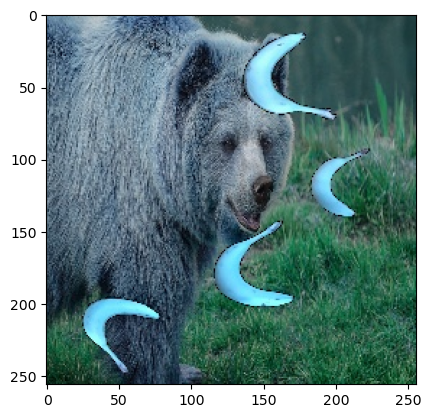

(torch.Size([1, 3, 256, 256]),
 torch.Size([256, 256, 3]),
 torch.Size([24, 6]),
 tensor([0.10, 0.08, 0.07, 0.05, 0.05, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02,
         0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
        device='cuda:0', grad_fn=<SelectBackward0>))

In [8]:
import cv2

# X = torch.from_numpy(cv2.imread('../data/banana-detection/bananas_val/images/20.png')).unsqueeze(0).float()
X = torch.from_numpy(cv2.imread('images/banana.jpg')).permute(2, 0, 1).unsqueeze(0).float()

img = X.squeeze(0).permute(1, 2, 0).long()
output = predict(X)
# output[:, 1] += .6
# output[:5, 0] = 1
display(img, output.cpu(), .6)
X.shape, img.shape, output.shape, output[:, 1]

In [ ]:
X.shape

torch.Size([1, 256, 256, 3])